# Постановка задачи и данные

Для корректной маршрутизации на нужного специалиста колл-центра решено отказаться от кнопочного меню и внедрить NLP модель.

Для этого была проведена разметка данных.

Атрибуты:

Text – запрос клиента
Label - метка


Задачи:

Требуется построить модель классификации клиентских запросов
Требуется предложить подход для решения этой задачи классификации или части задачи с использованием генеративных моделей (будет плюсом, если будет реализовано).

# Импорт библиотек и функций

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%pip install seaborn
import nltk
import re
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from nltk.corpus import words
!pip install pymystem3
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('words')
from sklearn.metrics import confusion_matrix
!pip install torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
!pip install sentencepiece sacremoses
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install scikit-learn-intelex --progress-bar off >> /tmp/pip_sklearnex.log
from sklearnex import patch_sklearn
from sklearn.svm import SVC
!pip install optuna
import optuna
import string
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 741.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [15]:
def explore_dataframe(df):
    # Вывод основной информации о датафрейме
    print("Информация о датафрейме:")
    print(df.info())

    # Вывод строк датафрейма
    print("\nПервые строки датафрейма:")
    display(df)

    # Вывод основных статистик по числовым данным
    print("\nОсновные статистики:")
    print(df.describe())

    # Проверка наличия пропущенных значений
    print("\nПропущенные значения:")
    print(df.isnull().sum())

    # Печать уникальных значений для каждой колонки
    print("\nУникальные значения в каждой колонке:")
    for column in df.columns:
        print(f"{column}: {df[column].unique()}")
   # Количество дубликатов
    print(f"Количество дубликатов: {df.duplicated().sum()}")

def cleaning(text):
    # Удаляем переводы строк
    text = re.sub(r"(?:\n|\r)", " ", text)
    # Удаляем спецсимволы и цифры, оставляем только русские и английские буквы
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", '', text)
    # Приводим к нижнему регистру
    text = text.lower()
    return text

# Лемматизация текста с помощью Mystem
def lemmatize_text(text):
    lemmas = mystem.lemmatize(text)
    # Объединение лемм в строку и удаление лишних символов
    processed_text = ''.join(lemmas).replace(' \n', '').strip()
    return processed_text

# Определение функции для категоризации текстов по их длине
def text_length_category(text):
    if len(text) <= 50:
        return 'до 50 символов'
    elif 50 < len(text) <= 100:
        return '51-100 символов'
    elif 100 < len(text) <= 150:
        return '101-150 символов'
    else:
        return 'больше 150 символов'

def has_english_words(text):
    words_in_text = text.split()
    for word in words_in_text:
        if word.lower() in english_words:
            return True
    return False

## Исследовательский анализ и предварительная обработка данных

In [2]:
df = pd.read_csv('/content/data.csv')

df_bert = pd.read_csv('/content/data.csv')

In [5]:
explore_dataframe(df)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32800 entries, 0 to 32799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    32709 non-null  object
 1   label   32800 non-null  object
dtypes: object(2)
memory usage: 512.6+ KB
None

Первые строки датафрейма:


,text,label
0,Как отключить тариф?,FAQ - тарифы и услуги
1,тариф,мобильная связь - тарифы
2,тариф,мобильная связь - тарифы
3,Здрасте я хотел получить золотую карту,FAQ - тарифы и услуги
4,Золотую карту,FAQ - тарифы и услуги
...,...,...
32795,Добрый день как можно с одного тарифа на друго...,FAQ - тарифы и услуги
32796,Как можно переходит тарифний план тариф,мобильная связь - тарифы
32797,Какие тарифы вы прилагаете,мобильная связь - тарифы
32798,тарифные тарифы есть,мобильная связь - тарифы



Основные статистики:
         text                     label
count   32709                     32800
unique  21029                        14
top     тариф  мобильная связь - тарифы
freq     2254                     12021

Пропущенные значения:
text     91
label     0
dtype: int64

Уникальные значения в каждой колонке:
text: ['Как отключить тариф?' 'тариф' 'Здрасте я хотел получить золотую карту '
 ... 'Какие тарифы вы прилагаете' 'тарифные тарифы есть' 'Тариф 80 сом']
label: ['FAQ - тарифы и услуги' 'мобильная связь - тарифы' 'Мобильный интернет'
 'FAQ - интернет' 'тарифы - подбор' 'Баланс' 'Мобильные услуги' 'Оплата'
 'Личный кабинет' 'SIM-карта и номер' 'Роуминг' 'запрос обратной связи'
 'Устройства' 'мобильная связь - зона обслуживания']
Количество дубликатов: 11510


Приведем названия столбца label к единой форме, а также поменяем тип данных у столбца text

In [6]:
df['label'] = df['label'].str.title()
df_bert['label'] = df['label'].str.title()

df_bert['text'] = df_bert['text'].astype(str)

Взглянем поближе на строки с пропусками

In [ ]:
rows_with_missing_values = df[df['text'].isnull()]

# Вывод строк с пропущенными значениями
print(rows_with_missing_values)

      text                     label
1422   NaN  мобильная связь - тарифы
1773   NaN  мобильная связь - тарифы
2563   NaN          Мобильные услуги
3788   NaN  мобильная связь - тарифы
3798   NaN  мобильная связь - тарифы
...    ...                       ...
27466  NaN  мобильная связь - тарифы
27664  NaN  мобильная связь - тарифы
27678  NaN          Мобильные услуги
27719  NaN  мобильная связь - тарифы
31351  NaN  мобильная связь - тарифы

[91 rows x 2 columns]


Количество пропусков незначительно - удалим их

In [ ]:
df = df.dropna(subset=['text'])

Посмотрим на распределение классов и длин текстов

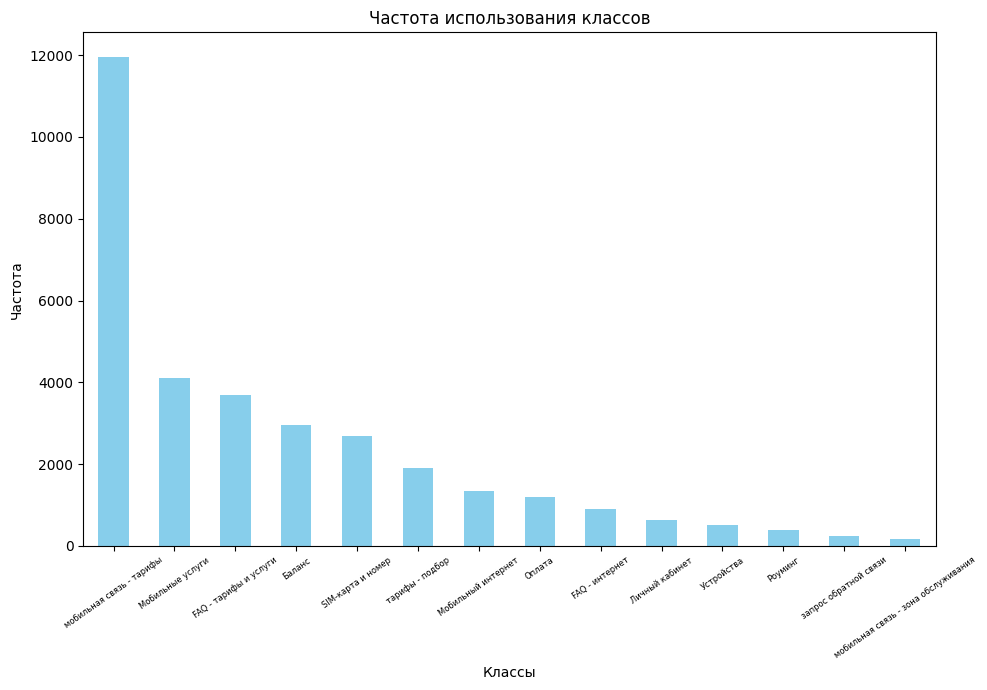

In [ ]:
class_counts = df['label'].value_counts()


plt.figure(figsize=(10, 7))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Частота использования классов')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(fontsize=6)
plt.xticks(rotation = 35)
plt.tight_layout()
plt.show()

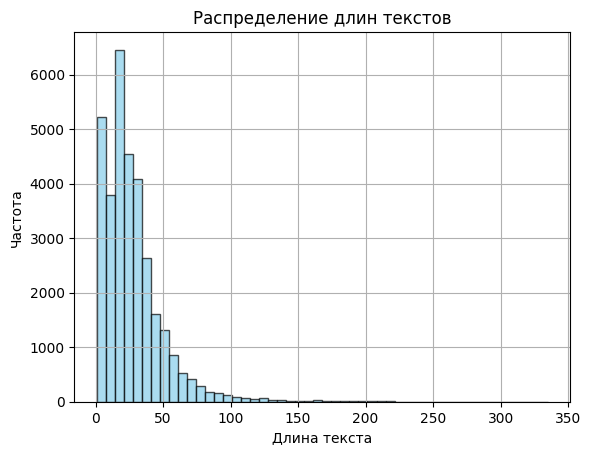

In [ ]:
text_lengths = df['text'].apply(len)

plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Распределение длин текстов')
plt.grid(True)
plt.show()

In [ ]:
# Применение функции к столбцу с текстом и подсчет числа сообщений в каждой категории
text_length_distribution = df['text'].apply(text_length_category).value_counts()

# Вывод результатов
print("Распределение текстов по длине:")
print(text_length_distribution)

Распределение текстов по длине:
text
до 50 символов         29007
51-100 символов         3193
101-150 символов         384
больше 150 символов      125
Name: count, dtype: int64


Выведем самые длинные тексты

In [ ]:
sorted_texts = df['text'].str.len().sort_values(ascending=False)


N = 10  # Количество текстов для отображения
for i, idx in enumerate(sorted_texts.index[:N]):
    print(f'Text {i + 1} (Length {len(df.loc[idx, "text"])}):')
    print(df.loc[idx, "text"])
    print()

Text 1 (Length 335):
Здравствуйте,мне на баланс поступило 115сом из которых у меня должны были взять 100сом за услугу интернета.Я проверила,на балансе осталось тарифго 20сом,а остальную часть забрали.Но интернет не подключается.Приходит такое сообщение,мол заплатите ещё 100сом,что на балансе недостаточно средств,для снятия еженедельной оплаты.Почему так?

Text 2 (Length 287):
Я живу в Таджикистане Согдийской области мой друг мне передал Сим карту от вашей компании. Поставил Сим карту в телефон антен нормальный. Как мне зарегистрироваться чтобы мне доехать до ближайшего Вашего офиса 100 километров. Можно ли зарегистрироваться через интернет. За ранее Спосибо!

Text 3 (Length 270):
Я нахожусь в Москве но у меня симка не работает я могу подключить роуминг и пользоваться услугами операторКыргызстан? На данном этапе у сим карты не выходит антенны как это исправить ? Номер телефона тариф. Можете помочь хоть чем то буду благодарен . За ранее спасибо...

Text 4 (Length 270):
Здравствуйте. Пока

In [ ]:
df['class_id'] = df['label'].factorize()[0]
df['class_id'].value_counts()

class_id
1     11959
6      4108
0      3684
5      2964
9      2681
4      1912
2      1355
7      1198
3       908
8       633
12      509
10      379
11      254
13      165
Name: count, dtype: int64

Проверим, все ли отзывы клиентов написаны на русском языке

In [ ]:
english_words = set(words.words())

df['has_english'] = df['text'].apply(has_english_words)

# Подавление предупреждения
pd.options.mode.chained_assignment = None  # default='warn'


if df['has_english'].any():
    print("Есть хотя бы одна строка с английскими символами в колонке")
else:
    print("Нет строк с английскими символами в колонке")


Есть хотя бы одна строка с английскими символами в колонке


In [ ]:
filtered_texts = df[df['has_english'] == True]['text']
print(filtered_texts)

409      Здраствуйте. У меня сейчас тариф . Закончился ...
615                               Почему не появляется 4 G
1244                                                   4 G
1568                                               тариф s
1652                           хотим подключить SIP номер 
                               ...                        
31974            как проверить поддерживает ли телефон 4 G
32084                                   Kak pereyti na p? 
32258       Скажите а приложение намба music еще работает?
32259      Не могу найти приложение namba music в appstore
32266                                          Статус gold
Name: text, Length: 166, dtype: object


Очистим датафрейм от специальных символов, заглавных букв и разделителей строк

In [ ]:
df['text'] = df['text'].apply(cleaning)

print(df.head(20))

                                                 text  \
0                                 как отключить тариф   
1                                               тариф   
2                                               тариф   
3             здрасте я хотел получить золотую карту    
4                                       золотую карту   
5                    как отключить доступ в интернет    
6          как запретить все звонки вне сети оператор   
7                                тарифы для интернета   
8                                               тариф   
9                                               тариф   
10                        тарифыбез абонентской платы   
11                                   проверить баланс   
12                                             услуга   
13               как перевести деньги еа другой номер   
14                                             услуга   
15               как проверить свой тариф и мигабайты   
16                         есть

In [ ]:
class_id_data = df[['label', 'class_id']].drop_duplicates().sort_values('class_id')

# Словарь для сверки id классов
class_to_id = dict(class_id_data.values)
id_to_class = dict(class_id_data[['class_id', 'label']].values)

id_to_class

{0: 'FAQ - тарифы и услуги',
 1: 'мобильная связь - тарифы',
 2: 'Мобильный интернет',
 3: 'FAQ - интернет',
 4: 'тарифы - подбор',
 5: 'Баланс',
 6: 'Мобильные услуги',
 7: 'Оплата',
 8: 'Личный кабинет',
 9: 'SIM-карта и номер',
 10: 'Роуминг',
 11: 'запрос обратной связи',
 12: 'Устройства',
 13: 'мобильная связь - зона обслуживания'}

Приступим к лемматизации текста

In [ ]:
mystem = Mystem()

df['lemmatized_text'] = df['text'].apply(lemmatize_text)
print(df)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


                                                    text  \
0                                    как отключить тариф   
1                                                  тариф   
2                                                  тариф   
3                здрасте я хотел получить золотую карту    
4                                          золотую карту   
...                                                  ...   
32795  добрый день как можно с одного тарифа на друго...   
32796            как можно переходит тарифний план тариф   
32797                         какие тарифы вы прилагаете   
32798                               тарифные тарифы есть   
32799                                         тариф  сом   

                          label  class_id  has_english  \
0         FAQ - тарифы и услуги         0        False   
1      мобильная связь - тарифы         1        False   
2      мобильная связь - тарифы         1        False   
3         FAQ - тарифы и услуги         0      

Посмотрим на среднюю длину комментариев в символах в столбце лемматизированного текста

In [ ]:
average_length = df['lemmatized_text'].apply(lambda x: len(x)).mean()
print("Длина символов в столбце lemmatized_text:", average_length)

Длина символов в столбце lemmatized_text: 26.882478828457


Выведем на экран и проверим, какие дубликаты в нашем датафрейме

In [ ]:
df[df.duplicated()]

,text,label,class_id,has_english,lemmatized_text
2,тариф,мобильная связь - тарифы,1,False,тариф
8,тариф,мобильная связь - тарифы,1,False,тариф
9,тариф,мобильная связь - тарифы,1,False,тариф
14,услуга,Мобильные услуги,6,False,услуга
23,тариф,мобильная связь - тарифы,1,False,тариф
...,...,...,...,...,...
32788,как сменить номер,SIM-карта и номер,9,False,как сменить номер
32789,мой баланс,Баланс,5,False,мой баланс
32792,тариф,мобильная связь - тарифы,1,False,тариф
32793,тарифы на месяц,мобильная связь - тарифы,1,False,тариф на месяц


Так как дубликатов строк слишком много, их удаление навредит обучению - оставим их

Добавим новые признаки в датафрейм и приступим к обучению

In [ ]:
df_new = df.copy()
# Признак 1: Длина текста
df_new['text_length'] = df_new['text'].apply(lambda x: len(x))

# Признак 2: Количество слов
df_new['word_count'] = df_new['text'].apply(lambda x: len(x.split()))

# Признак 3: Количество уникальных слов
df_new['unique_word_count'] = df_new['text'].apply(lambda x: len(set(x.split())))

# Признак 4: Наличие цифр
df_new['has_digits'] = df_new['text'].apply(lambda x: any(char.isdigit() for char in x))

# Признак 5: Наличие пунктуации
df_new['has_punctuation'] = df_new['text'].apply(lambda x: any(char in string.punctuation for char in x))

# Признак 6: Соотношение длины текста к количеству слов в тексте
df_new['text_density'] = df_new['text_length'] / df_new['word_count']


print(df_new.head())

                                      text                     label  \
0                      как отключить тариф     FAQ - тарифы и услуги   
1                                    тариф  мобильная связь - тарифы   
2                                    тариф  мобильная связь - тарифы   
3  здрасте я хотел получить золотую карту      FAQ - тарифы и услуги   
4                            золотую карту     FAQ - тарифы и услуги   

   class_id  has_english                          lemmatized_text  \
0         0        False                      как отключать тариф   
1         1        False                                    тариф   
2         1        False                                    тариф   
3         0        False  здрасте я хотеть получать золотой карта   
4         0        False                            золотой карта   

   text_length  word_count  unique_word_count  has_digits  has_punctuation  \
0           19           3                  3       False            False

# Обучение моделей

In [ ]:
df_new = df_new.drop(['text','has_english','text_length','word_count'], axis=1)

Кодируем категориальные признаки классов

In [ ]:
label_encoder = LabelEncoder()
df_new['label'] = label_encoder.fit_transform(df_new['label'])

Разделим наш датасет

In [ ]:
target = df_new['label']
features = df_new.drop(['label'], axis=1)

# Загрузка русского словаря стоп-слов
stopwords_ru = stopwords.words('russian')

features_train, features_test, target_train, target_test=train_test_split(df_new, target,test_size=0.1,random_state=42)

count_tf_idf = TfidfVectorizer(stop_words=stopwords_ru)

features_train_idf = count_tf_idf.fit_transform(features_train['lemmatized_text'])
features_test_idf = count_tf_idf.transform(features_test['lemmatized_text'])

print(features_train.shape)
print(features_test.shape)

(29438, 7)
(3271, 7)


*Dummy Model*

In [ ]:
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant'],
    'constant': [0, 1]
}

dummy = DummyClassifier(random_state=42)
dummy_gs = GridSearchCV(dummy, param_grid=dummy_grid, cv=5)
dummy_gs.fit(features_train, target_train)

print(dummy_gs.best_score_)

0.3654120503633651


*Logistic Regression*

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(features_train_idf, target_train)

y_pred = model_lr.predict(features_train_idf)


f1 = f1_score(target_train, y_pred, average='weighted')  # усредняем F1-меру для всех классов

print(f'F1-мера прогноза: {f1}')

F1-мера прогноза: 0.7881413356185824


*Random Forest*

In [ ]:
rfc_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42, class_weight='balanced')
rfc_model.fit(features_train_idf, target_train)


y_pred = rfc_model.predict(features_test_idf)


f1 = f1_score(target_test, y_pred, average='weighted')
print("F1-score:", f1)

F1-score: 0.6334226477706737


*Multinominal Naive Bayes*

In [ ]:
mnb_grid = {
    'alpha': [0.1, 0.2, 0.5, 0.8, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None]
}


mnb = MultinomialNB(class_prior='balanced')

mnb_tfidf_gs = GridSearchCV(mnb, param_grid=mnb_grid, cv=5, scoring='f1_weighted')
mnb_tfidf_gs.fit(features_train_idf, target_train)

# Вывод лучшего значения метрики
print(mnb_tfidf_gs.best_score_)

0.7376121722789195


*SVC*

In [ ]:
features_train_sub, features_val, target_train_sub, target_val = train_test_split(features_train_idf, target_train, random_state = 42, test_size=0.10)

In [ ]:
def objective(trial):
    from sklearn.svm import SVC
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e4, log=True),
        'kernel': trial.suggest_categorical("kernel", ["linear", "rbf"]),
        'class_weight': 'balanced'  # Добавляем параметр для учета дисбаланса классов
    }

    svc = SVC(**params)
    svc.fit(features_train_sub, target_train_sub)
    return svc.score(features_val, target_val)

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="maximize",
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=40, show_progress_bar=True)

[I 2024-04-02 08:31:10,380] A new study created in memory with name: no-name-3b9131b8-ccd4-4e6b-8167-48fc4413698a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-04-02 08:31:43,865] Trial 0 finished with value: 0.7462635869565217 and parameters: {'C': 37.30383528143735, 'gamma': 0.01945873840348015, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7462635869565217.
[I 2024-04-02 08:32:26,519] Trial 1 finished with value: 0.7180706521739131 and parameters: {'C': 56.98384608345693, 'gamma': 0.24257815076676031, 'kernel': 'linear'}. Best is trial 0 with value: 0.7462635869565217.
[I 2024-04-02 08:33:14,526] Trial 2 finished with value: 0.7238451086956522 and parameters: {'C': 0.7038096413827089, 'gamma': 0.13706928443177713, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7462635869565217.
[I 2024-04-02 08:35:16,160] Trial 3 finished with value: 0.005434782608695652 and parameters: {'C': 0.32253582308744194, 'gamma': 0.0003002086301848454, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7462635869565217.
[I 2024-04-02 08:37:17,577] Trial 4 finished with value: 0.034986413043478264 and parameters: {'C': 0.0028835922101179585, 'gamma': 0.0025

In [ ]:
print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

*BERT*

*Sberbank - ruBert-base*

In [ ]:
tokenizer = BertTokenizer.from_pretrained("sberbank-ai/ruBert-base")
model_bert = BertForSequenceClassification.from_pretrained("sberbank-ai/ruBert-base", num_labels=14)

X = df_bert['text'].tolist()
y = df_bert['label'].tolist()

# Кодирование меток классов
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Токенизация текста и создание масок внимания
train_inputs = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
train_labels = torch.tensor(y_train)
train_masks = train_inputs["attention_mask"]

test_inputs = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
test_labels = torch.tensor(y_test)
test_masks = test_inputs["attention_mask"]

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(train_inputs["input_ids"], train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_inputs["input_ids"], test_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Обучение модели
optimizer = torch.optim.AdamW(model_bert.parameters(), lr=5e-5)

model_bert.train()
for epoch in range(1):
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Оценка качества модели
model_bert.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1)
        predictions.extend(predicted_class.tolist())
        true_labels.extend(labels.tolist())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Evaluating: 100%|██████████| 410/410 [05:40<00:00,  1.20it/s]

                                     precision    recall  f1-score   support

                     FAQ - интернет       0.83      0.48      0.61       172
              FAQ - тарифы и услуги       0.78      0.69      0.73       740
                  SIM-карта и номер       0.79      0.96      0.87       559
                             Баланс       0.80      0.90      0.85       548
                     Личный кабинет       0.91      0.70      0.79       138
                   Мобильные услуги       0.83      0.69      0.75       838
                 Мобильный интернет       0.78      0.84      0.81       265
                             Оплата       0.76      0.83      0.79       240
                            Роуминг       0.64      0.59      0.61        78
                         Устройства       0.86      0.76      0.81       109
              запрос обратной связи       0.95      0.51      0.67        35
мобильная связь - зона обслуживания       0.45      0.63      0.52        2

*DeepPavlov - ruBert-base*

In [ ]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", num_labels=14)

X = df_bert['text'].tolist()
y = df_bert['label'].tolist()

# Кодирование меток классов
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Токенизация текста и создание масок внимания
train_inputs = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
train_labels = torch.tensor(y_train)
train_masks = train_inputs["attention_mask"]

test_inputs = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
test_labels = torch.tensor(y_test)
test_masks = test_inputs["attention_mask"]

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(train_inputs["input_ids"], train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_inputs["input_ids"], test_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Обучение модели
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(1):
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Оценка качества модели
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1)
        predictions.extend(predicted_class.tolist())
        true_labels.extend(labels.tolist())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Evaluating: 100%|██████████| 410/410 [05:57<00:00,  1.15it/s]

                                     precision    recall  f1-score   support

                     FAQ - интернет       0.51      0.70      0.59       172
              FAQ - тарифы и услуги       0.77      0.64      0.70       740
                  SIM-карта и номер       0.85      0.93      0.89       559
                             Баланс       0.85      0.87      0.86       548
                     Личный кабинет       0.82      0.78      0.80       138
                   Мобильные услуги       0.77      0.71      0.74       838
                 Мобильный интернет       0.91      0.72      0.80       265
                             Оплата       0.77      0.79      0.78       240
                            Роуминг       0.82      0.60      0.70        78
                         Устройства       0.83      0.83      0.83       109
              запрос обратной связи       0.70      0.74      0.72        35
мобильная связь - зона обслуживания       1.00      0.44      0.62        2

# Сравнение моделей

                                   Model  Score
0                sberbank-ai/ruBert-base  0.820
1  DeepPavlov/rubert-base-cased-sentence  0.810
2                    Logistic Regression  0.788
3                                    SVM  0.780
4               Multinominal Naive Bayes  0.737
5                          Random Forest  0.633
6                        DummyClassifier  0.365


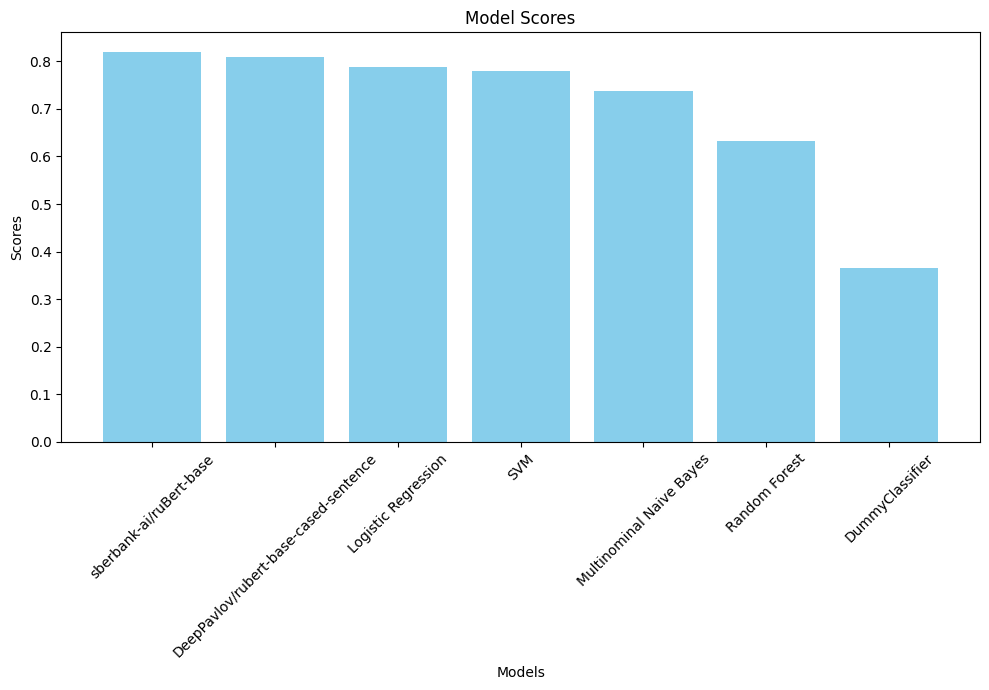

In [14]:
model_scores = {'sberbank-ai/ruBert-base': 0.820,
    'DeepPavlov/rubert-base-cased-sentence': 0.810,
    'Logistic Regression': 0.788,
    'SVM': 0.780,
    'Multinominal Naive Bayes': 0.737,
    'Random Forest': 0.633,
    'DummyClassifier': 0.365
}

# Создание таблицы из словаря
score_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Score'])


print(score_df)


plt.figure(figsize=(10, 7))
plt.bar(score_df['Model'], score_df['Score'], color='skyblue')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Вывод

В ходе данного исследования была проведена обработка текста и создание новых столбцов-признаков для улучшения качества данных. Далее были построены различные модели многоклассовой классификации для отзывов клиентов с учетом балансировки классов. Лучшими оказались вариации BERT от Сбера и DeepPavlov с показателями F1-score равными 0.820 и 0.810 соответственно, в то время как показатель baseline от Dummy Classifier составил 0.365.

Другие модели проявили себя наилучшим образом при обработке текста с использованием TF-IDF и метода GridSearch для подбора параметров. Однако, итоговый результат можно улучшить с использованием дополнительных методов.

В качестве одного из потенциальных способов улучшения результатов можно использовать генерацию синтетических данных с помощью генеративно-состязательных сетей (GAN). GAN позволяют создавать новые примеры данных, имитирующие характеристики и распределение исходного набора данных. В случае данной задачи, GAN могут быть использованы для создания синтетических текстовых образцов, которые будут содержать схожие с исходными образцы языковых характеристик и структуру. Эти синтетические данные могут быть затем использованы для увеличения размера обучающего набора данных и улучшения обобщающей способности модели.